# ML & RFID DOCK DOOR
Christophe Loussert, 9/11/2022

# PLAN

1. **tags**
    1. [tags](#tags)
    1. [embedded_sw](#embedded_sw)
    1. [formatting](#formatting)
    1. [first_visualization](#first_visualization)
    1. [reflist](#reflist)
    1. [visualization](#visualization)
    1. [Antenna_coverage](#Antenna_coverage)
    1. [Slots](#Slots)
    1. [visualization_full](#visualization_full)
1. **window prediction: crossing / no_crossing**
    1. [DATASET_window](#DATASET_window)
    1. [clf_window](#clf_window)
1. **EPC prediction: moving/stationary**
    1. [DATASET_EPC](#DATASET_EPC)
    1. [clf_EPC](#clf_EPC)
1. [**display_sw**](#display_sw)


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

import random

from scipy.signal import argrelmax
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
import pickle

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score

ModuleNotFoundError: No module named 'keras'

In [5]:
# pd.show_versions()

In [6]:
import sklearn
sklearn.show_versions()


System:
    python: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Felix 2\anaconda3\python.exe
   machine: Windows-10-10.0.19045-SP0

Python dependencies:
          pip: 22.2.2
   setuptools: 63.4.1
      sklearn: 1.0.2
        numpy: 1.21.5
        scipy: 1.9.1
       Cython: 0.29.32
       pandas: 1.4.4
   matplotlib: 3.5.2
       joblib: 1.1.0
threadpoolctl: 2.2.0

Built with OpenMP: True


C:\Users\Felix 2\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# tags

In [7]:
file='hwconf=2in2out__movingTOI=moving100u__movingxstart=-4__movingxstop=4__movingheight=1__speed=1__05-19-2022_16h_41m_47s.csv'
pathfile_runs = 'runs'
filename=os.path.join(pathfile_runs, file)
filename

'runs\\hwconf=2in2out__movingTOI=moving100u__movingxstart=-4__movingxstop=4__movingheight=1__speed=1__05-19-2022_16h_41m_47s.csv'

In [8]:
cols = ['Timestamp', 'EPC', 'TID', 'Antenna', 'RSSI', 'Frequency', 'Hostname', 'PhaseAngle', 'DopplerFrequency']
# 
# top3 rows: parameters

tags=pd.read_csv(filename, sep=';', names=cols)[3:]
# 
# gpio data eliminated
# 
tags = tags [ ~tags['EPC'].isna() ].reset_index(drop=True)
# 
# corrige un vieux bug d'ItemTest (peut-être résolu aujourd'hui)
tags = tags.drop_duplicates(['EPC', 'Timestamp', 'Antenna', 'RSSI']).reset_index(drop=True)
tags = tags [['EPC', 'Timestamp', 'Antenna', 'RSSI']]
tags.head()

,EPC,Timestamp,Antenna,RSSI
0,AD3830770CCDD0AD38300370,2022-05-19T16:41:50.0130790+02:00,1.0,"-66,5"
1,AD3830770CCDD0AD383002DB,2022-05-19T16:41:50.0153220+02:00,1.0,-66
2,E28068940000400A8070DD15,2022-05-19T16:41:50.0164810+02:00,1.0,-69
3,E2801190A50200602EE84CBB,2022-05-19T16:41:50.0180850+02:00,1.0,-66
4,E2801191A50200602A35C109,2022-05-19T16:41:50.0204060+02:00,1.0,"-65,5"


# embedded_sw
data received by SC in json must be converted into dataframe. Example for array

In [9]:
tags_raw = np.array(tags)
tags_raw

array([['AD3830770CCDD0AD38300370', '2022-05-19T16:41:50.0130790+02:00',
        1.0, '-66,5'],
       ['AD3830770CCDD0AD383002DB', '2022-05-19T16:41:50.0153220+02:00',
        1.0, '-66'],
       ['E28068940000400A8070DD15', '2022-05-19T16:41:50.0164810+02:00',
        1.0, '-69'],
       ...,
       ['AD3830770CCDD0AD383003D6', '2022-05-19T16:42:07.1609840+02:00',
        1.0, '-75,5'],
       ['AD3830770CCDD0AD3830041F', '2022-05-19T16:42:07.1705860+02:00',
        1.0, '-75,5'],
       ['AD3830770CCDD0AD383001D5', '2022-05-19T16:42:07.1834570+02:00',
        2.0, '-63,5']], dtype=object)

In [10]:
tags = pd.DataFrame(tags_raw, columns=['EPC', 'Timestamp', 'Antenna', 'RSSI'])
tags

,EPC,Timestamp,Antenna,RSSI
0,AD3830770CCDD0AD38300370,2022-05-19T16:41:50.0130790+02:00,1.0,"-66,5"
1,AD3830770CCDD0AD383002DB,2022-05-19T16:41:50.0153220+02:00,1.0,-66
2,E28068940000400A8070DD15,2022-05-19T16:41:50.0164810+02:00,1.0,-69
3,E2801190A50200602EE84CBB,2022-05-19T16:41:50.0180850+02:00,1.0,-66
4,E2801191A50200602A35C109,2022-05-19T16:41:50.0204060+02:00,1.0,"-65,5"
...,...,...,...,...
1533,AD3830770CCDD0AD3830035B,2022-05-19T16:42:07.1255730+02:00,1.0,-60
1534,AD3830770CCDD0AD38300482,2022-05-19T16:42:07.1492230+02:00,1.0,-72
1535,AD3830770CCDD0AD383003D6,2022-05-19T16:42:07.1609840+02:00,1.0,"-75,5"
1536,AD3830770CCDD0AD3830041F,2022-05-19T16:42:07.1705860+02:00,1.0,"-75,5"


# formatting

In [11]:
tags.dtypes

EPC          object
Timestamp    object
Antenna      object
RSSI         object
dtype: object

In [12]:
tags['Timestamp'] = pd.to_datetime(tags['Timestamp'])
tags['Timestamp'] = tags['Timestamp'].apply(lambda x:x.to_datetime64())
tags['Antenna'] = tags['Antenna'].astype(int)
tags['RSSIdbm'] = tags['RSSI'].apply(lambda x:x.replace(',','.')).astype(float)
tags['RSSI'] = 10**6 * 10**(tags['RSSIdbm']/10) # microW
# 
tags = tags.sort_values('Timestamp', ascending=True).reset_index(drop=True)
# 
tags.head()

,EPC,Timestamp,Antenna,RSSI,RSSIdbm
0,AD3830770CCDD0AD38300370,2022-05-19 14:41:50.013079,1,0.223872,-66.5
1,AD3830770CCDD0AD383002DB,2022-05-19 14:41:50.015322,1,0.251189,-66.0
2,E28068940000400A8070DD15,2022-05-19 14:41:50.016481,1,0.125893,-69.0
3,E2801190A50200602EE84CBB,2022-05-19 14:41:50.018085,1,0.251189,-66.0
4,E2801191A50200602A35C109,2022-05-19 14:41:50.020406,1,0.281838,-65.5


In [13]:
tags.dtypes

EPC                  object
Timestamp    datetime64[ns]
Antenna               int32
RSSI                float64
RSSIdbm             float64
dtype: object

# first_visualization
stationay tags at +/-1m are not discarded yet

(19131.612384410637, 19131.61258314186)

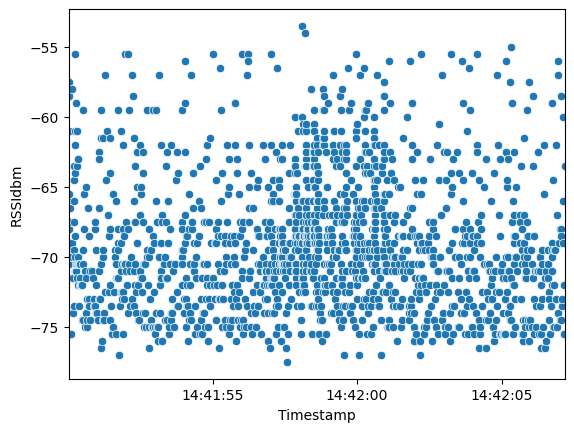

In [14]:
sns.scatterplot(data=tags, x='Timestamp', y='RSSIdbm')
Tmin=tags['Timestamp'].min()
Tmax=tags['Timestamp'].max()
plt.xlim(Tmin, Tmax)

# reflist
needed to eliminate +/-1m stationary tags
not needed in embedded sw ... stationary tags: +/-2m, +/-3m, +/-4m ... not +/-1m !!!

In [15]:
pathfile_reflist = 'reflist_student - simple'
Files = os.listdir(pathfile_reflist)
reflist=pd.DataFrame()
for file in Files:
    actual=file.rstrip('.csv')
    filename=os.path.join(pathfile_reflist, file)
    temp=pd.read_csv(filename, sep=';', names=['EPC'])
    temp['actual'] = actual
    reflist = reflist.append(temp)
reflist = reflist.reset_index(drop=True)
reflist.head()

C:\Users\Felix 2\AppData\Local\Temp\ipykernel_14504\4144829901.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reflist = reflist.append(temp)
C:\Users\Felix 2\AppData\Local\Temp\ipykernel_14504\4144829901.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reflist = reflist.append(temp)


,EPC,actual
0,AD3830770CCDD0AD38300206,moving
1,AD3830770CCDD0AD383004A5,moving
2,AD3830770CCDD0AD3830041F,moving
3,AD3830770CCDD0AD38300450,moving
4,AD3830770CCDD0AD3830028A,moving


In [16]:
reflist.groupby('actual').size()

actual
moving        100
stationary     80
dtype: int64

In [17]:
reflist.tail()

,EPC,actual
175,AD3830770CCDD0AD383002E3,stationary
176,AD3830770CCDD0AD38300217,stationary
177,AD3830770CCDD0AD3830035C,stationary
178,AD3830770CCDD0AD38300326,stationary
179,AD3830770CCDD0AD383001DD,stationary


In [18]:
reflist.shape

(180, 2)

# merge_tags_reflist

In [19]:
# 
# merge with how=inner (tags shared between tags and reflist)
# 
tags = pd.merge(tags, reflist,on='EPC', how='inner')
tags.head()

,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual
0,AD3830770CCDD0AD3830047A,2022-05-19 14:41:50.053503,1,0.112202,-69.5,stationary
1,AD3830770CCDD0AD3830047A,2022-05-19 14:41:51.721659,1,0.070795,-71.5,stationary
2,AD3830770CCDD0AD3830047A,2022-05-19 14:41:53.322045,1,0.089125,-70.5,stationary
3,AD3830770CCDD0AD3830047A,2022-05-19 14:41:54.937755,1,0.125893,-69.0,stationary
4,AD3830770CCDD0AD3830047A,2022-05-19 14:41:56.650639,1,0.089125,-70.5,stationary


In [20]:
tags.shape

(808, 6)

In [21]:
tags.groupby('actual') ['EPC'].nunique()

actual
moving        100
stationary     40
Name: EPC, dtype: int64

# visualization
+/-1m stationary tags eliminated

(19131.612384878506, 19131.612582992893)

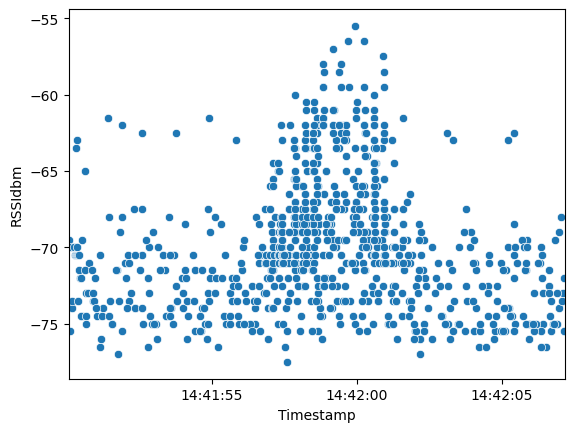

In [22]:
sns.scatterplot(data=tags, x='Timestamp', y='RSSIdbm')
Tmin=tags['Timestamp'].min()
Tmax=tags['Timestamp'].max()
plt.xlim(Tmin, Tmax)

# Antenna_coverage
Antenna 1 and 2 point towards zone IN
Antenna 3 and 4 point towards zone OUT

In [23]:
Antenna_coverage_dict = {1:'ain', 2:'ain', 3:'aout', 4:'aout'}
Antenna_coverage_dict

{1: 'ain', 2: 'ain', 3: 'aout', 4: 'aout'}

In [24]:
tags['Antenna'].map(Antenna_coverage_dict)

0       ain
1       ain
2       ain
3       ain
4       ain
       ... 
803    aout
804    aout
805     ain
806    aout
807     ain
Name: Antenna, Length: 808, dtype: object

In [25]:
tags['Antenna_coverage'] = tags['Antenna'].map(Antenna_coverage_dict)
tags.head()

,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual,Antenna_coverage
0,AD3830770CCDD0AD3830047A,2022-05-19 14:41:50.053503,1,0.112202,-69.5,stationary,ain
1,AD3830770CCDD0AD3830047A,2022-05-19 14:41:51.721659,1,0.070795,-71.5,stationary,ain
2,AD3830770CCDD0AD3830047A,2022-05-19 14:41:53.322045,1,0.089125,-70.5,stationary,ain
3,AD3830770CCDD0AD3830047A,2022-05-19 14:41:54.937755,1,0.125893,-69.0,stationary,ain
4,AD3830770CCDD0AD3830047A,2022-05-19 14:41:56.650639,1,0.089125,-70.5,stationary,ain


# Slots

In [26]:
# in S1/ST: 1 read/sec
timedelta = pd.Timedelta(1, unit='sec')
# 
Tmin = tags['Timestamp'].min()
Tmax = tags['Timestamp'].max()
#     slot_id
Slots = pd.DataFrame({'slotStart':pd.date_range(start=Tmin, end=Tmax, freq=timedelta)})
Slots['slot_id']=range(0,len(Slots))                 

Slots

,slotStart,slot_id
0,2022-05-19 14:41:50.053503,0
1,2022-05-19 14:41:51.053503,1
2,2022-05-19 14:41:52.053503,2
3,2022-05-19 14:41:53.053503,3
4,2022-05-19 14:41:54.053503,4
5,2022-05-19 14:41:55.053503,5
6,2022-05-19 14:41:56.053503,6
7,2022-05-19 14:41:57.053503,7
8,2022-05-19 14:41:58.053503,8
9,2022-05-19 14:41:59.053503,9


In [27]:
tags = tags.sort_values('Timestamp', ascending=True)
Slots = Slots.sort_values('slotStart', ascending=True)
tags = pd.merge_asof(tags, Slots, left_on='Timestamp', right_on='slotStart', direction='backward')
tags


,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual,Antenna_coverage,slotStart,slot_id
0,AD3830770CCDD0AD3830047A,2022-05-19 14:41:50.053503,1,0.112202,-69.5,stationary,ain,2022-05-19 14:41:50.053503,0
1,AD3830770CCDD0AD3830039C,2022-05-19 14:41:50.092369,1,0.028184,-75.5,stationary,ain,2022-05-19 14:41:50.053503,0
2,AD3830770CCDD0AD38300324,2022-05-19 14:41:50.123705,2,0.100000,-70.0,stationary,ain,2022-05-19 14:41:50.053503,0
3,AD3830770CCDD0AD383002E6,2022-05-19 14:41:50.157848,2,0.039811,-74.0,stationary,ain,2022-05-19 14:41:50.053503,0
4,AD3830770CCDD0AD383002A5,2022-05-19 14:41:50.182130,2,0.044668,-73.5,stationary,ain,2022-05-19 14:41:50.053503,0
...,...,...,...,...,...,...,...,...,...
803,AD3830770CCDD0AD38300312,2022-05-19 14:42:07.080570,4,0.044668,-73.5,stationary,aout,2022-05-19 14:42:07.053503,17
804,AD3830770CCDD0AD38300453,2022-05-19 14:42:07.097300,4,0.050119,-73.0,stationary,aout,2022-05-19 14:42:07.053503,17
805,AD3830770CCDD0AD38300482,2022-05-19 14:42:07.149223,1,0.063096,-72.0,moving,ain,2022-05-19 14:42:07.053503,17
806,AD3830770CCDD0AD383003D6,2022-05-19 14:42:07.160984,1,0.028184,-75.5,moving,ain,2022-05-19 14:42:07.053503,17


# visualization_full

In [28]:
tags[:1]

,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual,Antenna_coverage,slotStart,slot_id
0,AD3830770CCDD0AD3830047A,2022-05-19 14:41:50.053503,1,0.112202,-69.5,stationary,ain,2022-05-19 14:41:50.053503,0


(19131.612384878506, 19131.612582992893)

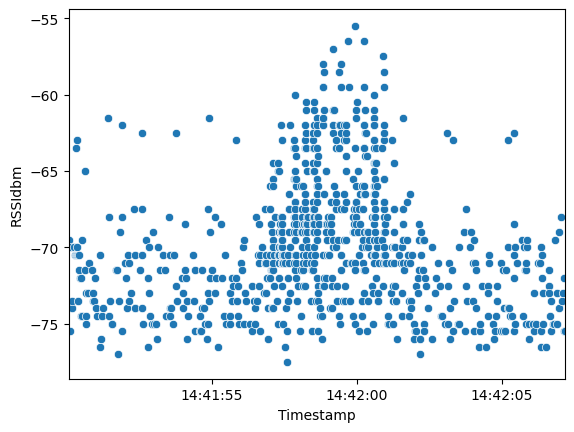

In [29]:
sns.scatterplot(data=tags, x='Timestamp', y='RSSIdbm')
Tmin=tags['Timestamp'].min()
Tmax=tags['Timestamp'].max()
plt.xlim(Tmin, Tmax)

(19131.612384878506, 19131.612582992893)

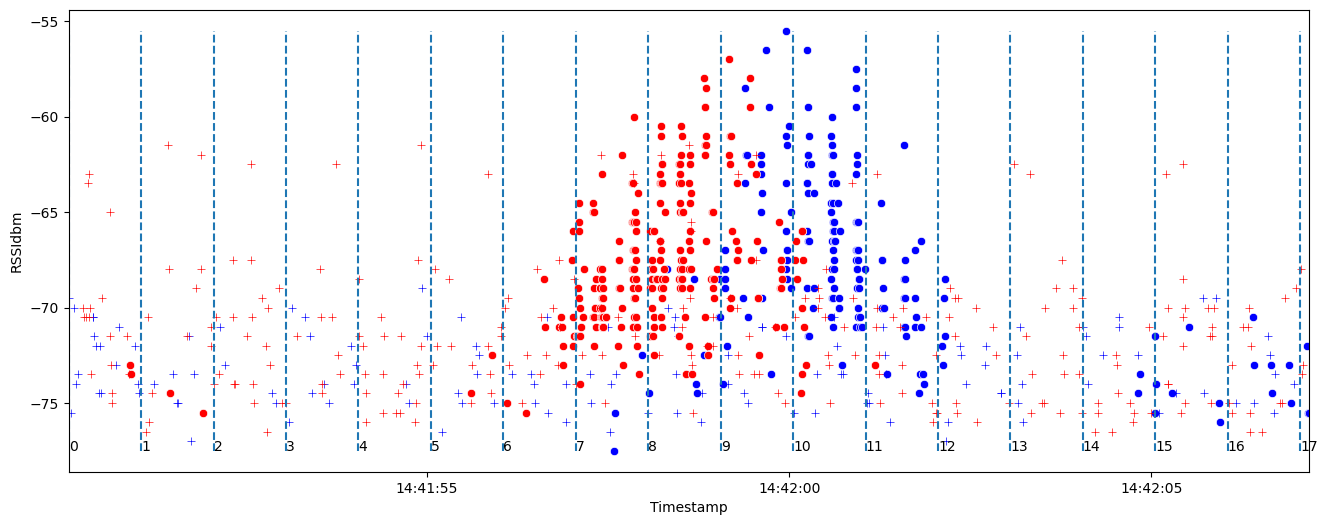

In [30]:
plt.figure(figsize=(16,6))
Colors={'ain':'blue', 'aout':'red'}
Markers={'moving':'o', 'stationary':'+'}
for ant_cov in ['ain', 'aout']:
    tags_ant_cov = tags [ tags['Antenna_coverage']==ant_cov ]
    color=Colors[ant_cov]
    for actual in ['moving', 'stationary']:
        marker=Markers[actual]
        tags_actual = tags_ant_cov [ tags_ant_cov['actual']==actual ]
        sns.scatterplot(data=tags_actual, x='Timestamp', y='RSSIdbm', color=color, marker=marker)
#         
plt.vlines(Slots['slotStart'], ymin=tags['RSSIdbm'].min(), ymax=tags['RSSIdbm'].max(), linestyle='dashed')
/
for i, row in Slots.iterrows():
    slot_id=row['slot_id']
    slotStart=row['slotStart']
    plt.annotate(slot_id, (slotStart, tags['RSSIdbm'].min() ))
#       
Tmin=tags['Timestamp'].min()
Tmax=tags['Timestamp'].max()
plt.xlim(Tmin, Tmax)

In [31]:
EPC_list = tags['EPC'].unique()
rand_idx = random.randrange(len(EPC_list))
EPC_random = EPC_list[rand_idx]
EPC_random 

'AD3830770CCDD0AD383003E6'

In [32]:
tags_EPC = tags [ tags['EPC']==EPC_random ]
tags_EPC.head()

,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual,Antenna_coverage,slotStart,slot_id
187,AD3830770CCDD0AD383003E6,2022-05-19 14:41:57.082207,4,0.125893,-69.0,moving,aout,2022-05-19 14:41:57.053503,7
289,AD3830770CCDD0AD383003E6,2022-05-19 14:41:58.078188,3,0.125893,-69.0,moving,aout,2022-05-19 14:41:58.053503,8
365,AD3830770CCDD0AD383003E6,2022-05-19 14:41:58.612815,4,0.223872,-66.5,moving,aout,2022-05-19 14:41:58.053503,8
441,AD3830770CCDD0AD383003E6,2022-05-19 14:41:59.292219,4,0.199526,-67.0,moving,aout,2022-05-19 14:41:59.053503,9
500,AD3830770CCDD0AD383003E6,2022-05-19 14:41:59.969824,1,0.141254,-68.5,moving,ain,2022-05-19 14:41:59.053503,9


(19131.612384878506, 19131.612582992893)

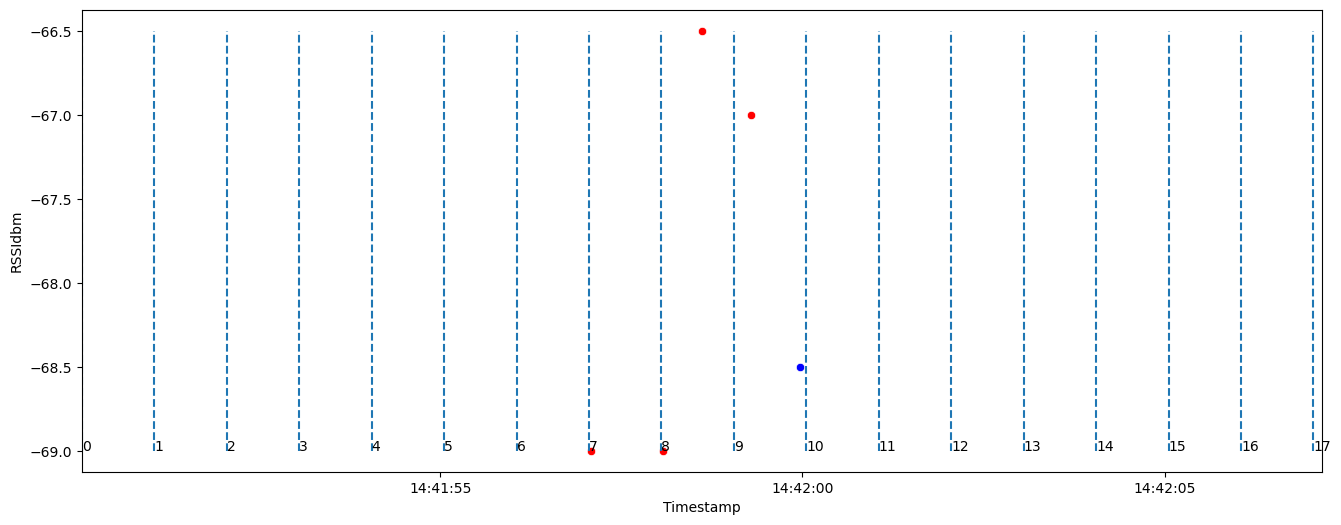

In [33]:
plt.figure(figsize=(16,6))
Colors={'ain':'blue', 'aout':'red'}
Markers={'moving':'o', 'stationary':'+'}
for ant_cov in ['ain', 'aout']:
    tags_EPC_ant_cov = tags_EPC [ tags_EPC['Antenna_coverage']==ant_cov ]
    color=Colors[ant_cov]
    for actual in ['moving', 'stationary']:
        marker=Markers[actual]
        tags_EPC_actual = tags_EPC_ant_cov [ tags_EPC_ant_cov['actual']==actual ]
        sns.scatterplot(data=tags_EPC_actual, x='Timestamp', y='RSSIdbm', color=color, marker=marker)
#         
plt.vlines(Slots['slotStart'], ymin=tags_EPC['RSSIdbm'].min(), ymax=tags_EPC['RSSIdbm'].max(), linestyle='dashed')
/
for i, row in Slots.iterrows():
    slot_id=row['slot_id']
    slotStart=row['slotStart']
    plt.annotate(slot_id, (slotStart, tags_EPC['RSSIdbm'].min() ))
#       
Tmin=tags['Timestamp'].min()
Tmax=tags['Timestamp'].max()
plt.xlim(Tmin, Tmax)

# DATASET_EPC

### average slot_center = 9

In [34]:

# Slots_id = [6, 7, 8, 9] #no crossing
# Slots_id = [7, 8, 9, 10] #crossing
# Slots_id = [8, 9, 10, 11] #crossing
# Slots_id = [9, 10, 11, 12] #no crosing
# slot_center=9 ... 10 = 9.5 = 9
Slots_id = range(6,12)
tags_window = tags [tags['slot_id'].isin(Slots_id)].reset_index(drop=True)
Slots_id_normalized = [-3, -2, -1, 0, 1, 2]
dict_slot_normalized = dict(zip(Slots_id, Slots_id_normalized))
tags_window.loc[:, 'slot_id_norm'] = tags_window.loc[:, 'slot_id'].map(dict_slot_normalized)
tags_window.head()

,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual,Antenna_coverage,slotStart,slot_id,slot_id_norm
0,AD3830770CCDD0AD383001FB,2022-05-19 14:41:56.074573,4,0.100000,-70.0,stationary,aout,2022-05-19 14:41:56.053503,6,-3
1,AD3830770CCDD0AD38300494,2022-05-19 14:41:56.099250,4,0.031623,-75.0,moving,aout,2022-05-19 14:41:56.053503,6,-3
2,AD3830770CCDD0AD3830021C,2022-05-19 14:41:56.116291,4,0.112202,-69.5,stationary,aout,2022-05-19 14:41:56.053503,6,-3
3,AD3830770CCDD0AD38300453,2022-05-19 14:41:56.128048,4,0.050119,-73.0,stationary,aout,2022-05-19 14:41:56.053503,6,-3
4,AD3830770CCDD0AD38300288,2022-05-19 14:41:56.176829,1,0.044668,-73.5,stationary,ain,2022-05-19 14:41:56.053503,6,-3


In [35]:
tags_window['slot_id_norm'].unique()

array([-3, -2, -1,  0,  1,  2], dtype=int64)

In [36]:
tags_window.tail()

,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual,Antenna_coverage,slotStart,slot_id,slot_id_norm
520,AD3830770CCDD0AD383001D3,2022-05-19 14:42:01.966659,3,0.031623,-75.0,stationary,aout,2022-05-19 14:42:01.053503,11,2
521,AD3830770CCDD0AD38300342,2022-05-19 14:42:01.978410,3,0.025119,-76.0,stationary,aout,2022-05-19 14:42:01.053503,11,2
522,AD3830770CCDD0AD383001DD,2022-05-19 14:42:02.021205,4,0.028184,-75.5,stationary,aout,2022-05-19 14:42:01.053503,11,2
523,AD3830770CCDD0AD38300308,2022-05-19 14:42:02.031357,4,0.056234,-72.5,stationary,aout,2022-05-19 14:42:01.053503,11,2
524,AD3830770CCDD0AD3830026D,2022-05-19 14:42:02.040941,4,0.028184,-75.5,stationary,aout,2022-05-19 14:42:01.053503,11,2


In [37]:
tags_window.groupby(['EPC', 'slot_id_norm', 'Antenna_coverage'])['RSSI'].max()

EPC                       slot_id_norm  Antenna_coverage
AD3830770CCDD0AD383001C3  -2            aout                0.112202
                          -1            aout                0.056234
                           0            aout                0.056234
AD3830770CCDD0AD383001C4  -3            aout                0.100000
                          -1            aout                0.079433
                                                              ...   
AD3830770CCDD0AD383004B2  -1            aout                0.158489
                           1            aout                0.177828
                           2            ain                 0.079433
AD3830770CCDD0AD383004B3  -3            aout                0.070795
                           0            ain                 0.316228
Name: RSSI, Length: 458, dtype: float64

In [38]:
temp = tags_window.groupby(['EPC', 'slot_id_norm', 'Antenna_coverage'])['RSSI'].max()\
    .unstack(['slot_id_norm','Antenna_coverage'],fill_value=0)
temp

slot_id_norm,-2,-1,0,-3,1,2,0,1,2,-2,-1,-3
Antenna_coverage,aout,aout,aout,aout,aout,aout,ain,ain,ain,ain,ain,ain
EPC,,,,,,,,,,,,
AD3830770CCDD0AD383001C3,0.112202,0.056234,0.056234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383001C4,0.000000,0.079433,0.079433,0.100000,0.100000,0.089125,0.000000,0.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383001C8,0.251189,0.141254,0.000000,0.000000,0.000000,0.000000,0.794328,1.778279,0.707946,0.0,0.0,0.0
AD3830770CCDD0AD383001C9,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.199526,0.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383001CB,0.100000,0.177828,0.000000,0.000000,0.100000,0.000000,0.630957,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
AD3830770CCDD0AD383004AA,0.050119,0.316228,0.000000,0.000000,0.000000,0.000000,0.501187,0.281838,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383004AF,0.158489,0.079433,0.177828,0.000000,0.000000,0.000000,0.125893,1.000000,0.000000,0.0,0.0,0.0


In [39]:
temp.columns = sorted(temp.columns)


In [40]:
temp.columns = ["_".join([str(y) for y in x]) for x in temp.columns]
temp

,-3_ain,-3_aout,-2_ain,-2_aout,-1_ain,-1_aout,0_ain,0_aout,1_ain,1_aout,2_ain,2_aout
EPC,,,,,,,,,,,,
AD3830770CCDD0AD383001C3,0.112202,0.056234,0.056234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383001C4,0.000000,0.079433,0.079433,0.100000,0.100000,0.089125,0.000000,0.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383001C8,0.251189,0.141254,0.000000,0.000000,0.000000,0.000000,0.794328,1.778279,0.707946,0.0,0.0,0.0
AD3830770CCDD0AD383001C9,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.199526,0.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383001CB,0.100000,0.177828,0.000000,0.000000,0.100000,0.000000,0.630957,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
AD3830770CCDD0AD383004AA,0.050119,0.316228,0.000000,0.000000,0.000000,0.000000,0.501187,0.281838,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383004AF,0.158489,0.079433,0.177828,0.000000,0.000000,0.000000,0.125893,1.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383004B1,0.070795,0.223872,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.0,0.0,0.0


In [41]:
sorted(["_".join([str(y) for y in x]) for x in temp.columns])

['-_1___a_i_n',
 '-_1___a_o_u_t',
 '-_2___a_i_n',
 '-_2___a_o_u_t',
 '-_3___a_i_n',
 '-_3___a_o_u_t',
 '0___a_i_n',
 '0___a_o_u_t',
 '1___a_i_n',
 '1___a_o_u_t',
 '2___a_i_n',
 '2___a_o_u_t']

In [42]:
temp.columns = ["max_" + x for x in temp.columns]
temp

,max_-3_ain,max_-3_aout,max_-2_ain,max_-2_aout,max_-1_ain,max_-1_aout,max_0_ain,max_0_aout,max_1_ain,max_1_aout,max_2_ain,max_2_aout
EPC,,,,,,,,,,,,
AD3830770CCDD0AD383001C3,0.112202,0.056234,0.056234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383001C4,0.000000,0.079433,0.079433,0.100000,0.100000,0.089125,0.000000,0.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383001C8,0.251189,0.141254,0.000000,0.000000,0.000000,0.000000,0.794328,1.778279,0.707946,0.0,0.0,0.0
AD3830770CCDD0AD383001C9,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.199526,0.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383001CB,0.100000,0.177828,0.000000,0.000000,0.100000,0.000000,0.630957,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
AD3830770CCDD0AD383004AA,0.050119,0.316228,0.000000,0.000000,0.000000,0.000000,0.501187,0.281838,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383004AF,0.158489,0.079433,0.177828,0.000000,0.000000,0.000000,0.125893,1.000000,0.000000,0.0,0.0,0.0
AD3830770CCDD0AD383004B1,0.070795,0.223872,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.0,0.0,0.0


In [43]:
temp_len = tags_window.groupby(['EPC', 'slot_id_norm', 'Antenna_coverage'])['RSSI'].size()\
    .unstack(['slot_id_norm','Antenna_coverage'],fill_value=0)
temp_len

slot_id_norm,-2,-1,0,-3,1,2,0,1,2,-2,-1,-3
Antenna_coverage,aout,aout,aout,aout,aout,aout,ain,ain,ain,ain,ain,ain
EPC,,,,,,,,,,,,
AD3830770CCDD0AD383001C3,1,1,1,0,0,0,0,0,0,0,0,0
AD3830770CCDD0AD383001C4,0,1,2,1,2,1,0,0,0,0,0,0
AD3830770CCDD0AD383001C8,1,1,0,0,0,0,1,1,1,0,0,0
AD3830770CCDD0AD383001C9,0,1,0,0,0,0,1,0,0,0,0,0
AD3830770CCDD0AD383001CB,1,1,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
AD3830770CCDD0AD383004AA,1,1,0,0,0,0,1,1,0,0,0,0
AD3830770CCDD0AD383004AF,2,1,1,0,0,0,1,1,0,0,0,0


In [44]:
temp_len.columns = ["_".join([str(y) for y in x]) for x in temp_len.columns]
temp_len.columns = ["len_" + x for x in temp_len.columns]
temp_len

,len_-2_aout,len_-1_aout,len_0_aout,len_-3_aout,len_1_aout,len_2_aout,len_0_ain,len_1_ain,len_2_ain,len_-2_ain,len_-1_ain,len_-3_ain
EPC,,,,,,,,,,,,
AD3830770CCDD0AD383001C3,1,1,1,0,0,0,0,0,0,0,0,0
AD3830770CCDD0AD383001C4,0,1,2,1,2,1,0,0,0,0,0,0
AD3830770CCDD0AD383001C8,1,1,0,0,0,0,1,1,1,0,0,0
AD3830770CCDD0AD383001C9,0,1,0,0,0,0,1,0,0,0,0,0
AD3830770CCDD0AD383001CB,1,1,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
AD3830770CCDD0AD383004AA,1,1,0,0,0,0,1,1,0,0,0,0
AD3830770CCDD0AD383004AF,2,1,1,0,0,0,1,1,0,0,0,0
AD3830770CCDD0AD383004B1,1,1,0,0,0,0,0,1,0,0,0,0


In [45]:
pd.concat([temp,temp_len],axis=1)

,max_-3_ain,max_-3_aout,max_-2_ain,max_-2_aout,max_-1_ain,max_-1_aout,max_0_ain,max_0_aout,max_1_ain,max_1_aout,...,len_0_aout,len_-3_aout,len_1_aout,len_2_aout,len_0_ain,len_1_ain,len_2_ain,len_-2_ain,len_-1_ain,len_-3_ain
EPC,,,,,,,,,,,,,,,,,,,,,
AD3830770CCDD0AD383001C3,0.112202,0.056234,0.056234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,0
AD3830770CCDD0AD383001C4,0.000000,0.079433,0.079433,0.100000,0.100000,0.089125,0.000000,0.000000,0.000000,0.0,...,2,1,2,1,0,0,0,0,0,0
AD3830770CCDD0AD383001C8,0.251189,0.141254,0.000000,0.000000,0.000000,0.000000,0.794328,1.778279,0.707946,0.0,...,0,0,0,0,1,1,1,0,0,0
AD3830770CCDD0AD383001C9,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.199526,0.000000,0.000000,0.0,...,0,0,0,0,1,0,0,0,0,0
AD3830770CCDD0AD383001CB,0.100000,0.177828,0.000000,0.000000,0.100000,0.000000,0.630957,0.000000,0.000000,0.0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AD3830770CCDD0AD383004AA,0.050119,0.316228,0.000000,0.000000,0.000000,0.000000,0.501187,0.281838,0.000000,0.0,...,0,0,0,0,1,1,0,0,0,0
AD3830770CCDD0AD383004AF,0.158489,0.079433,0.177828,0.000000,0.000000,0.000000,0.125893,1.000000,0.000000,0.0,...,1,0,0,0,1,1,0,0,0,0
AD3830770CCDD0AD383004B1,0.070795,0.223872,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.0,...,0,0,0,0,0,1,0,0,0,0


# Pivot table

In [46]:
ds = pd.pivot_table(data=tags_window,index=["EPC"],values=["RSSI"],columns=["slot_id_norm","Antenna_coverage"],\
                    aggfunc=[max,min,len,np.mean,sum],fill_value=0)
ds

max                                          \
                         RSSI                                           
slot_id_norm               -3             -2             -1             
Antenna_coverage          ain      aout  ain      aout  ain      aout   
EPC                                                                     
AD3830770CCDD0AD383001C3  0.0  0.000000  0.0  0.112202  0.0  0.056234   
AD3830770CCDD0AD383001C4  0.0  0.100000  0.0  0.000000  0.0  0.079433   
AD3830770CCDD0AD383001C8  0.0  0.000000  0.0  0.251189  0.0  0.141254   
AD3830770CCDD0AD383001C9  0.0  0.000000  0.0  0.000000  0.0  0.100000   
AD3830770CCDD0AD383001CB  0.0  0.000000  0.0  0.100000  0.0  0.177828   
...                       ...       ...  ...       ...  ...       ...   
AD3830770CCDD0AD383004AA  0.0  0.000000  0.0  0.050119  0.0  0.316228   
AD3830770CCDD0AD383004AF  0.0  0.000000  0.0  0.158489  0.0  0.079433   
AD3830770CCDD0AD383004B1  0.0  0.000000  0.0  0.070795  0.0  0.223872   
AD3830770CCDD0AD383004B2  0.0  0.000000  0.0  0.000000  0.0  0.158489   
AD3830770CCDD0AD383004B3  0.0  0.070795  0.0  0.000000  0.0  0.000000   

                                                                  ...  sum  \
                                                                  ... RSSI   
slot_id_norm                     0                   1            ...   -2   
Antenna_coverage               ain      aout       ain      aout  ...  ain   
EPC                                                               ...        
AD3830770CCDD0AD383001C3  0.000000  0.056234  0.000000  0.000000  ...  0.0   
AD3830770CCDD0AD383001C4  0.000000  0.079433  0.000000  0.100000  ...  0.0   
AD3830770CCDD0AD383001C8  0.794328  0.000000  1.778279  0.000000  ...  0.0   
AD3830770CCDD0AD383001C9  0.199526  0.000000  0.000000  0.000000  ...  0.0   
AD3830770CCDD0AD383001CB  0.630957  0.000000  0.000000  0.100000  ...  0.0   
...                            ...       ...       ...       ...  ...  ...   
AD3830770CCDD0AD383004AA  0.501187  0.000000  0.281838  0.000000  ...  0.0   
AD3830770CCDD0AD383004AF  0.125893  0.177828  1.000000  0.000000  ...  0.0   
AD3830770CCDD0AD383004B1  0.000000  0.000000  0.100000  0.000000  ...  0.0   
AD3830770CCDD0AD383004B2  0.000000  0.000000  0.000000  0.177828  ...  0.0   
AD3830770CCDD0AD383004B3  0.316228  0.000000  0.000000  0.000000  ...  0.0   

                                                                       \
                                                                        
slot_id_norm                         -1                   0             
Antenna_coverage              aout  ain      aout       ain      aout   
EPC                                                                     
AD3830770CCDD0AD383001C3  0.112202  0.0  0.056234  0.000000  0.056234   
AD3830770CCDD0AD383001C4  0.000000  0.0  0.079433  0.000000  0.150227   
AD3830770CCDD0AD383001C8  0.251189  0.0  0.141254  0.794328  0.000000   
AD3830770CCDD0AD383001C9  0.000000  0.0  0.100000  0.199526  0.000000   
AD3830770CCDD0AD383001CB  0.100000  0.0  0.177828  0.630957  0.000000   
...                            ...  ...       ...       ...       ...   
AD3830770CCDD0AD383004AA  0.050119  0.0  0.316228  0.501187  0.000000   
AD3830770CCDD0AD383004AF  0.203158  0.0  0.079433  0.125893  0.177828   
AD3830770CCDD0AD383004B1  0.070795  0.0  0.223872  0.000000  0.000000   
AD3830770CCDD0AD383004B2  0.000000  0.0  0.158489  0.000000  0.000000   
AD3830770CCDD0AD383004B3  0.000000  0.0  0.000000  0.379324  0.000000   

                                                                  
                                                                  
slot_id_norm                     1                   2            
Antenna_coverage               ain      aout       ain      aout  
EPC                                                               
AD3830770CCDD0AD383001C3  0.000000  0.000000  0.000000  0.000000  
AD3830770CCDD0AD383001C4  0.000000  0

In [47]:
Xcols_ds = ["_".join([str(y) for y in x if y != 'RSSI']) for x in ds.columns]
ds.columns = Xcols_ds
ds

,max_-3_ain,max_-3_aout,max_-2_ain,max_-2_aout,max_-1_ain,max_-1_aout,max_0_ain,max_0_aout,max_1_ain,max_1_aout,...,sum_-2_ain,sum_-2_aout,sum_-1_ain,sum_-1_aout,sum_0_ain,sum_0_aout,sum_1_ain,sum_1_aout,sum_2_ain,sum_2_aout
EPC,,,,,,,,,,,,,,,,,,,,,
AD3830770CCDD0AD383001C3,0.0,0.000000,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,...,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000
AD3830770CCDD0AD383001C4,0.0,0.100000,0.0,0.000000,0.0,0.079433,0.000000,0.079433,0.000000,0.100000,...,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125
AD3830770CCDD0AD383001C8,0.0,0.000000,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,...,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000
AD3830770CCDD0AD383001C9,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000
AD3830770CCDD0AD383001CB,0.0,0.000000,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,...,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AD3830770CCDD0AD383004AA,0.0,0.000000,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000,...,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000,0.000000,0.000000
AD3830770CCDD0AD383004AF,0.0,0.000000,0.0,0.158489,0.0,0.079433,0.125893,0.177828,1.000000,0.000000,...,0.0,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000,0.000000,0.000000
AD3830770CCDD0AD383004B1,0.0,0.000000,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,...,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000


In [48]:
ds = ds.reset_index(drop=False)
ds

,EPC,max_-3_ain,max_-3_aout,max_-2_ain,max_-2_aout,max_-1_ain,max_-1_aout,max_0_ain,max_0_aout,max_1_ain,...,sum_-2_ain,sum_-2_aout,sum_-1_ain,sum_-1_aout,sum_0_ain,sum_0_aout,sum_1_ain,sum_1_aout,sum_2_ain,sum_2_aout
0,AD3830770CCDD0AD383001C3,0.0,0.000000,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,...,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000
1,AD3830770CCDD0AD383001C4,0.0,0.100000,0.0,0.000000,0.0,0.079433,0.000000,0.079433,0.000000,...,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125
2,AD3830770CCDD0AD383001C8,0.0,0.000000,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,...,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000
3,AD3830770CCDD0AD383001C9,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,...,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000
4,AD3830770CCDD0AD383001CB,0.0,0.000000,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,...,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,AD3830770CCDD0AD383004AA,0.0,0.000000,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,...,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000,0.000000,0.000000
135,AD3830770CCDD0AD383004AF,0.0,0.000000,0.0,0.158489,0.0,0.079433,0.125893,0.177828,1.000000,...,0.0,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000,0.000000,0.000000
136,AD3830770CCDD0AD383004B1,0.0,0.000000,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,...,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000
137,AD3830770CCDD0AD383004B2,0.0,0.000000,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828,0.079433,0.000000


In [49]:
pd.merge(ds,reflist,left_on='EPC',right_on='EPC',how='outer') 

,EPC,max_-3_ain,max_-3_aout,max_-2_ain,max_-2_aout,max_-1_ain,max_-1_aout,max_0_ain,max_0_aout,max_1_ain,...,sum_-2_aout,sum_-1_ain,sum_-1_aout,sum_0_ain,sum_0_aout,sum_1_ain,sum_1_aout,sum_2_ain,sum_2_aout,actual
0,AD3830770CCDD0AD383001C3,0.0,0.0,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,...,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000,moving
1,AD3830770CCDD0AD383001C4,0.0,0.1,0.0,0.000000,0.0,0.079433,0.000000,0.079433,0.000000,...,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125,stationary
2,AD3830770CCDD0AD383001C8,0.0,0.0,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,...,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000,moving
3,AD3830770CCDD0AD383001C9,0.0,0.0,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,...,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000,moving
4,AD3830770CCDD0AD383001CB,0.0,0.0,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,...,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000,moving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,AD3830770CCDD0AD383002F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stationary
176,AD3830770CCDD0AD383001E7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stationary
177,AD3830770CCDD0AD383001CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stationary
178,AD3830770CCDD0AD383002A0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stationary


In [50]:
ds = pd.merge(ds,reflist) 
ds

,EPC,max_-3_ain,max_-3_aout,max_-2_ain,max_-2_aout,max_-1_ain,max_-1_aout,max_0_ain,max_0_aout,max_1_ain,...,sum_-2_aout,sum_-1_ain,sum_-1_aout,sum_0_ain,sum_0_aout,sum_1_ain,sum_1_aout,sum_2_ain,sum_2_aout,actual
0,AD3830770CCDD0AD383001C3,0.0,0.000000,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,...,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000,moving
1,AD3830770CCDD0AD383001C4,0.0,0.100000,0.0,0.000000,0.0,0.079433,0.000000,0.079433,0.000000,...,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125,stationary
2,AD3830770CCDD0AD383001C8,0.0,0.000000,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,...,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000,moving
3,AD3830770CCDD0AD383001C9,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,...,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000,moving
4,AD3830770CCDD0AD383001CB,0.0,0.000000,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,...,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000,moving
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,AD3830770CCDD0AD383004AA,0.0,0.000000,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,...,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000,0.000000,0.000000,moving
135,AD3830770CCDD0AD383004AF,0.0,0.000000,0.0,0.158489,0.0,0.079433,0.125893,0.177828,1.000000,...,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000,0.000000,0.000000,moving
136,AD3830770CCDD0AD383004B1,0.0,0.000000,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,...,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,moving
137,AD3830770CCDD0AD383004B2,0.0,0.000000,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,...,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828,0.079433,0.000000,moving


In [51]:
Xcols_ds

['max_-3_ain',
 'max_-3_aout',
 'max_-2_ain',
 'max_-2_aout',
 'max_-1_ain',
 'max_-1_aout',
 'max_0_ain',
 'max_0_aout',
 'max_1_ain',
 'max_1_aout',
 'max_2_ain',
 'max_2_aout',
 'min_-3_ain',
 'min_-3_aout',
 'min_-2_ain',
 'min_-2_aout',
 'min_-1_ain',
 'min_-1_aout',
 'min_0_ain',
 'min_0_aout',
 'min_1_ain',
 'min_1_aout',
 'min_2_ain',
 'min_2_aout',
 'len_-3_ain',
 'len_-3_aout',
 'len_-2_ain',
 'len_-2_aout',
 'len_-1_ain',
 'len_-1_aout',
 'len_0_ain',
 'len_0_aout',
 'len_1_ain',
 'len_1_aout',
 'len_2_ain',
 'len_2_aout',
 'mean_-3_ain',
 'mean_-3_aout',
 'mean_-2_ain',
 'mean_-2_aout',
 'mean_-1_ain',
 'mean_-1_aout',
 'mean_0_ain',
 'mean_0_aout',
 'mean_1_ain',
 'mean_1_aout',
 'mean_2_ain',
 'mean_2_aout',
 'sum_-3_ain',
 'sum_-3_aout',
 'sum_-2_ain',
 'sum_-2_aout',
 'sum_-1_ain',
 'sum_-1_aout',
 'sum_0_ain',
 'sum_0_aout',
 'sum_1_ain',
 'sum_1_aout',
 'sum_2_ain',
 'sum_2_aout']

In [52]:
X = ds.loc[:,Xcols_ds]
y = ds.loc[:,"actual"]
X

,max_-3_ain,max_-3_aout,max_-2_ain,max_-2_aout,max_-1_ain,max_-1_aout,max_0_ain,max_0_aout,max_1_ain,max_1_aout,...,sum_-2_ain,sum_-2_aout,sum_-1_ain,sum_-1_aout,sum_0_ain,sum_0_aout,sum_1_ain,sum_1_aout,sum_2_ain,sum_2_aout
0,0.0,0.000000,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,...,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000
1,0.0,0.100000,0.0,0.000000,0.0,0.079433,0.000000,0.079433,0.000000,0.100000,...,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125
2,0.0,0.000000,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,...,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000
3,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,...,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0.0,0.000000,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000,...,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000,0.000000,0.000000
135,0.0,0.000000,0.0,0.158489,0.0,0.079433,0.125893,0.177828,1.000000,0.000000,...,0.0,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000,0.000000,0.000000
136,0.0,0.000000,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,...,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000
137,0.0,0.000000,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828,...,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828,0.079433,0.000000


In [53]:
for key, ds_key in ds.groupby(['actual']):
    print(key)
    print(ds_key)

moving
                          EPC  max_-3_ain  max_-3_aout  max_-2_ain  \
0    AD3830770CCDD0AD383001C3         0.0     0.000000         0.0   
2    AD3830770CCDD0AD383001C8         0.0     0.000000         0.0   
3    AD3830770CCDD0AD383001C9         0.0     0.000000         0.0   
4    AD3830770CCDD0AD383001CB         0.0     0.000000         0.0   
5    AD3830770CCDD0AD383001CE         0.0     0.000000         0.0   
..                        ...         ...          ...         ...   
134  AD3830770CCDD0AD383004AA         0.0     0.000000         0.0   
135  AD3830770CCDD0AD383004AF         0.0     0.000000         0.0   
136  AD3830770CCDD0AD383004B1         0.0     0.000000         0.0   
137  AD3830770CCDD0AD383004B2         0.0     0.000000         0.0   
138  AD3830770CCDD0AD383004B3         0.0     0.070795         0.0   

     max_-2_aout  max_-1_ain  max_-1_aout  max_0_ain  max_0_aout  max_1_ain  \
0       0.112202         0.0     0.056234   0.000000    0.056234   0.0000

In [54]:
ds.groupby(['actual']).size()

actual
moving        100
stationary     39
dtype: int64

In [92]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8)

In [93]:
Scaler = StandardScaler()

In [94]:
Scaler.fit(X_train)

StandardScaler()

In [95]:
X_train.head()

,max_-3_ain,max_-3_aout,max_-2_ain,max_-2_aout,max_-1_ain,max_-1_aout,max_0_ain,max_0_aout,max_1_ain,max_1_aout,...,sum_-2_ain,sum_-2_aout,sum_-1_ain,sum_-1_aout,sum_0_ain,sum_0_aout,sum_1_ain,sum_1_aout,sum_2_ain,sum_2_aout
136,0.000000,0.000000,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,...,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000
109,0.000000,0.000000,0.0,0.039811,0.0,0.158489,0.000000,0.000000,0.177828,0.044668,...,0.0,0.039811,0.0,0.158489,0.000000,0.000000,0.177828,0.044668,0.079433,0.000000
107,0.000000,0.000000,0.0,0.079433,0.0,0.112202,0.000000,0.000000,0.251189,0.000000,...,0.0,0.079433,0.0,0.112202,0.000000,0.000000,0.251189,0.000000,0.000000,0.000000
70,0.000000,0.158489,0.0,0.000000,0.0,0.000000,0.000000,0.112202,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.112202,0.000000,0.000000,0.000000,0.079433
121,0.089125,0.000000,0.0,0.000000,0.1,0.000000,0.070795,0.000000,0.063096,0.000000,...,0.0,0.000000,0.1,0.000000,0.070795,0.000000,0.063096,0.000000,0.000000,0.000000


In [96]:
X_train['max_-3_ain'].describe()

count    111.000000
mean       0.002732
std        0.011722
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.089125
Name: max_-3_ain, dtype: float64

In [97]:
X_train_sc = Scaler.transform(X_train)

In [98]:
X_test_sc = Scaler.transform(X_test)

In [99]:
Clf_knn = KNeighborsClassifier()

In [100]:
Clf_knn.fit(X_train_sc,y_train)

KNeighborsClassifier()

In [101]:
y_pred = Clf_knn.predict(X_test_sc)

C:\Users\Felix 2\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [105]:
(y_test == y_pred).mean()

0.9642857142857143

In [106]:
X_test_sc[:1]

array([[-0.23407192, -0.40818581, -0.26204026,  0.31791696, -0.33407763,
         0.53255976,  1.50297334, -0.39250729, -0.56807281, -0.37843587,
        -0.35606284, -0.23202263, -0.23330461, -0.40735038, -0.26204026,
         0.64736198, -0.3315171 ,  0.92586014,  1.51350503, -0.38885093,
        -0.51590405, -0.37667472, -0.35300048, -0.23202263, -0.24735697,
        -0.47118823, -0.27869321,  0.4839186 , -0.36103495,  0.27372166,
         1.47511548, -0.60100251, -0.9226514 , -0.46297257, -0.54590804,
        -0.39528471, -0.23373168, -0.40777649, -0.26204026,  0.47580767,
        -0.33283558,  0.73967856,  1.50931253, -0.39083064, -0.54740111,
        -0.37759574, -0.35458112, -0.23202263, -0.23006585, -0.41252248,
        -0.26204026,  0.15340371, -0.34343291,  0.33216547,  1.49835843,
        -0.39743285, -0.58305451, -0.38539738, -0.36272334, -0.23202263]])

In [91]:
for n in range(1,10):
    Clf_knn = KNeighborsClassifier(n_neighbors=n)
    Clf_knn.fit(X_train_sc,y_train)
    y_pred = Clf_knn.predict(X_test_sc)
    print((y_test == y_pred).mean())

0.8214285714285714
0.8214285714285714
0.8928571428571429
0.9642857142857143
0.9642857142857143
0.9642857142857143
0.9642857142857143
0.9285714285714286
0.9285714285714286


C:\Users\Felix 2\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Felix 2\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

In [107]:
Clf_svc = SVC()

In [108]:
Clf_svc.fit(X_train_sc,y_train)

SVC()

In [109]:
Clf_svc.predict(X_test_sc)

array(['moving', 'moving', 'stationary', 'moving', 'moving', 'moving',
       'moving', 'stationary', 'moving', 'moving', 'moving', 'moving',
       'moving', 'stationary', 'stationary', 'moving', 'moving', 'moving',
       'moving', 'moving', 'stationary', 'moving', 'moving', 'stationary',
       'moving', 'moving', 'moving', 'moving'], dtype=object)

In [110]:
(y_test == y_pred).mean()

0.9642857142857143

In [111]:
# Ultra simple dataset

In [115]:
tags

,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual,Antenna_coverage,slotStart,slot_id
0,AD3830770CCDD0AD3830047A,2022-05-19 14:41:50.053503,1,0.112202,-69.5,stationary,ain,2022-05-19 14:41:50.053503,0
1,AD3830770CCDD0AD3830039C,2022-05-19 14:41:50.092369,1,0.028184,-75.5,stationary,ain,2022-05-19 14:41:50.053503,0
2,AD3830770CCDD0AD38300324,2022-05-19 14:41:50.123705,2,0.100000,-70.0,stationary,ain,2022-05-19 14:41:50.053503,0
3,AD3830770CCDD0AD383002E6,2022-05-19 14:41:50.157848,2,0.039811,-74.0,stationary,ain,2022-05-19 14:41:50.053503,0
4,AD3830770CCDD0AD383002A5,2022-05-19 14:41:50.182130,2,0.044668,-73.5,stationary,ain,2022-05-19 14:41:50.053503,0
...,...,...,...,...,...,...,...,...,...
803,AD3830770CCDD0AD38300312,2022-05-19 14:42:07.080570,4,0.044668,-73.5,stationary,aout,2022-05-19 14:42:07.053503,17
804,AD3830770CCDD0AD38300453,2022-05-19 14:42:07.097300,4,0.050119,-73.0,stationary,aout,2022-05-19 14:42:07.053503,17
805,AD3830770CCDD0AD38300482,2022-05-19 14:42:07.149223,1,0.063096,-72.0,moving,ain,2022-05-19 14:42:07.053503,17
806,AD3830770CCDD0AD383003D6,2022-05-19 14:42:07.160984,1,0.028184,-75.5,moving,ain,2022-05-19 14:42:07.053503,17


In [117]:
tags_obs = tags[tags['slot_id'].isin(Slots_id)]

In [118]:
tags_obs

,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual,Antenna_coverage,slotStart,slot_id
149,AD3830770CCDD0AD383001FB,2022-05-19 14:41:56.074573,4,0.100000,-70.0,stationary,aout,2022-05-19 14:41:56.053503,6
150,AD3830770CCDD0AD38300494,2022-05-19 14:41:56.099250,4,0.031623,-75.0,moving,aout,2022-05-19 14:41:56.053503,6
151,AD3830770CCDD0AD3830021C,2022-05-19 14:41:56.116291,4,0.112202,-69.5,stationary,aout,2022-05-19 14:41:56.053503,6
152,AD3830770CCDD0AD38300453,2022-05-19 14:41:56.128048,4,0.050119,-73.0,stationary,aout,2022-05-19 14:41:56.053503,6
153,AD3830770CCDD0AD38300288,2022-05-19 14:41:56.176829,1,0.044668,-73.5,stationary,ain,2022-05-19 14:41:56.053503,6
...,...,...,...,...,...,...,...,...,...
669,AD3830770CCDD0AD383001D3,2022-05-19 14:42:01.966659,3,0.031623,-75.0,stationary,aout,2022-05-19 14:42:01.053503,11
670,AD3830770CCDD0AD38300342,2022-05-19 14:42:01.978410,3,0.025119,-76.0,stationary,aout,2022-05-19 14:42:01.053503,11
671,AD3830770CCDD0AD383001DD,2022-05-19 14:42:02.021205,4,0.028184,-75.5,stationary,aout,2022-05-19 14:42:01.053503,11
672,AD3830770CCDD0AD38300308,2022-05-19 14:42:02.031357,4,0.056234,-72.5,stationary,aout,2022-05-19 14:42:01.053503,11


In [124]:
ds = tags_obs.groupby('EPC')['RSSIdbm'].max().rename('RSSIMax').reset_index(drop=False)

In [126]:
ds = pd.merge(ds,reflist)

In [132]:
ds.groupby('actual')['RSSIMax'].describe()

,count,mean,std,min,25%,50%,75%,max
actual,,,,,,,,
moving,100.0,-63.270000,3.215666,-69.5,-66.0,-63.0,-61.375,-55.5
stationary,39.0,-71.089744,3.316370,-76.5,-73.5,-71.0,-70.000,-61.5


<AxesSubplot:xlabel='actual', ylabel='RSSIMax'>

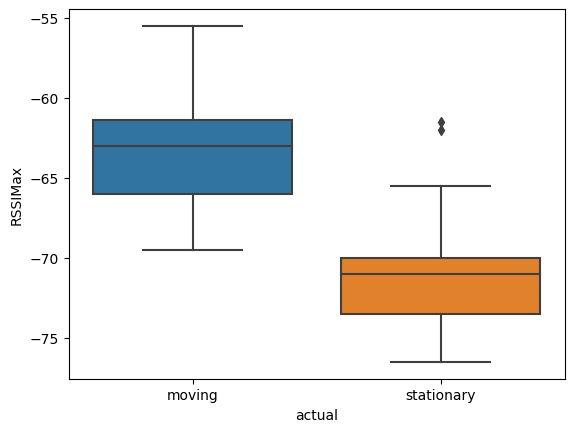

In [133]:
sns.boxplot(data=ds,x='actual',y='RSSIMax')

In [157]:
threshold = -69.5
crit = ds['RSSIMax'] > threshold
ds['pred'] = np.where(crit,'moving','stationary')
(ds['actual'] == ds['pred']).mean()

0.9424460431654677

In [147]:
Clf_dt = DecisionTreeClassifier(max_depth=1)

In [168]:
X_obs = ds.loc[:,['RSSIMax']]
y_obs = ds.loc[:,'actual']

Clf_dt.fit(X_obs,y_obs)

DecisionTreeClassifier(max_depth=1)

In [169]:
y_pred = Clf_dt.predict(X_obs)

In [ ]:
threshold = Clf_dt.tree_.threshold[0]

In [171]:
(y_pred == y_obs).mean()

0.9424460431654677

[Text(0.5, 0.75, 'RSSIMax <= -69.75\ngini = 0.404\nsamples = 139\nvalue = [100, 39]\nclass = moving'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 31\nvalue = [0, 31]\nclass = stationary'),
 Text(0.75, 0.25, 'gini = 0.137\nsamples = 108\nvalue = [100, 8]\nclass = moving')]

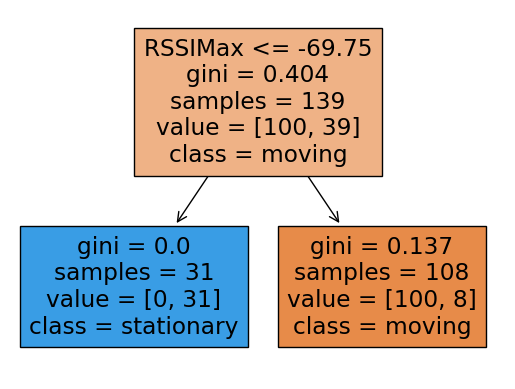

In [177]:
plot_tree(Clf_dt,class_names=['moving','stationary'],filled=True,feature_names=['RSSIMax'])

In [55]:
tags_window.groupby('actual') ['EPC'].nunique()

actual
moving        100
stationary     39
Name: EPC, dtype: int64

In [56]:
pd.pivot_table(data=tags_window, index='EPC', columns=['slot_id_norm', 'Antenna_coverage'], values='RSSI', \
               aggfunc=[max, min, np.mean, sum, len], fill_value=0)

max                                          \
slot_id_norm               -3             -2             -1             
Antenna_coverage          ain      aout  ain      aout  ain      aout   
EPC                                                                     
AD3830770CCDD0AD383001C3  0.0  0.000000  0.0  0.112202  0.0  0.056234   
AD3830770CCDD0AD383001C4  0.0  0.100000  0.0  0.000000  0.0  0.079433   
AD3830770CCDD0AD383001C8  0.0  0.000000  0.0  0.251189  0.0  0.141254   
AD3830770CCDD0AD383001C9  0.0  0.000000  0.0  0.000000  0.0  0.100000   
AD3830770CCDD0AD383001CB  0.0  0.000000  0.0  0.100000  0.0  0.177828   
...                       ...       ...  ...       ...  ...       ...   
AD3830770CCDD0AD383004AA  0.0  0.000000  0.0  0.050119  0.0  0.316228   
AD3830770CCDD0AD383004AF  0.0  0.000000  0.0  0.158489  0.0  0.079433   
AD3830770CCDD0AD383004B1  0.0  0.000000  0.0  0.070795  0.0  0.223872   
AD3830770CCDD0AD383004B2  0.0  0.000000  0.0  0.000000  0.0  0.158489   
AD3830770CCDD0AD383004B3  0.0  0.070795  0.0  0.000000  0.0  0.000000   

                                                                  ... len  \
slot_id_norm                     0                   1            ...  -2   
Antenna_coverage               ain      aout       ain      aout  ... ain   
EPC                                                               ...       
AD3830770CCDD0AD383001C3  0.000000  0.056234  0.000000  0.000000  ...   0   
AD3830770CCDD0AD383001C4  0.000000  0.079433  0.000000  0.100000  ...   0   
AD3830770CCDD0AD383001C8  0.794328  0.000000  1.778279  0.000000  ...   0   
AD3830770CCDD0AD383001C9  0.199526  0.000000  0.000000  0.000000  ...   0   
AD3830770CCDD0AD383001CB  0.630957  0.000000  0.000000  0.100000  ...   0   
...                            ...       ...       ...       ...  ...  ..   
AD3830770CCDD0AD383004AA  0.501187  0.000000  0.281838  0.000000  ...   0   
AD3830770CCDD0AD383004AF  0.125893  0.177828  1.000000  0.000000  ...   0   
AD3830770CCDD0AD383004B1  0.000000  0.000000  0.100000  0.000000  ...   0   
AD3830770CCDD0AD383004B2  0.000000  0.000000  0.000000  0.177828  ...   0   
AD3830770CCDD0AD383004B3  0.316228  0.000000  0.000000  0.000000  ...   0   

                                                                   
slot_id_norm                   -1        0        1        2       
Antenna_coverage         aout ain aout ain aout ain aout ain aout  
EPC                                                                
AD3830770CCDD0AD383001C3    1   0    1   0    1   0    0   0    0  
AD3830770CCDD0AD383001C4    0   0    1   0    2   0    2   0    1  
AD3830770CCDD0AD383001C8    1   0    1   1    0   1    0   1    0  
AD3830770CCDD0AD383001C9    0   0    1   1    0   0    0   0    0  
AD3830770CCDD0AD383001CB    1   0    1   1    0   0    1   0    0  
...                       ...  ..  ...  ..  ...  ..  ...  ..  ...  
AD3830770CCDD0AD383004AA    1   0    1   1    0   1    0   0    0  
AD3830770CCDD0AD383004AF    2   0    1   1    1   1    0   0    0  
AD3830770CCDD0AD383004B1    1   0    1   0    0   1    0   0    0  
AD3830770CCDD0AD383004B2    0   0    1   0    0   0    1   1    0  
AD3830770CCDD0AD383004B3    0   0    0   2    0   0    0   0    0  

[139 rows x 60 columns]

In [57]:
ds_EPC = pd.pivot_table(data=tags_window, index='EPC', columns=['slot_id_norm', 'Antenna_coverage'], values='RSSI', \
               aggfunc=[max, min, np.mean, sum, len], fill_value=0)
ds_EPC

max                                          \
slot_id_norm               -3             -2             -1             
Antenna_coverage          ain      aout  ain      aout  ain      aout   
EPC                                                                     
AD3830770CCDD0AD383001C3  0.0  0.000000  0.0  0.112202  0.0  0.056234   
AD3830770CCDD0AD383001C4  0.0  0.100000  0.0  0.000000  0.0  0.079433   
AD3830770CCDD0AD383001C8  0.0  0.000000  0.0  0.251189  0.0  0.141254   
AD3830770CCDD0AD383001C9  0.0  0.000000  0.0  0.000000  0.0  0.100000   
AD3830770CCDD0AD383001CB  0.0  0.000000  0.0  0.100000  0.0  0.177828   
...                       ...       ...  ...       ...  ...       ...   
AD3830770CCDD0AD383004AA  0.0  0.000000  0.0  0.050119  0.0  0.316228   
AD3830770CCDD0AD383004AF  0.0  0.000000  0.0  0.158489  0.0  0.079433   
AD3830770CCDD0AD383004B1  0.0  0.000000  0.0  0.070795  0.0  0.223872   
AD3830770CCDD0AD383004B2  0.0  0.000000  0.0  0.000000  0.0  0.158489   
AD3830770CCDD0AD383004B3  0.0  0.070795  0.0  0.000000  0.0  0.000000   

                                                                  ... len  \
slot_id_norm                     0                   1            ...  -2   
Antenna_coverage               ain      aout       ain      aout  ... ain   
EPC                                                               ...       
AD3830770CCDD0AD383001C3  0.000000  0.056234  0.000000  0.000000  ...   0   
AD3830770CCDD0AD383001C4  0.000000  0.079433  0.000000  0.100000  ...   0   
AD3830770CCDD0AD383001C8  0.794328  0.000000  1.778279  0.000000  ...   0   
AD3830770CCDD0AD383001C9  0.199526  0.000000  0.000000  0.000000  ...   0   
AD3830770CCDD0AD383001CB  0.630957  0.000000  0.000000  0.100000  ...   0   
...                            ...       ...       ...       ...  ...  ..   
AD3830770CCDD0AD383004AA  0.501187  0.000000  0.281838  0.000000  ...   0   
AD3830770CCDD0AD383004AF  0.125893  0.177828  1.000000  0.000000  ...   0   
AD3830770CCDD0AD383004B1  0.000000  0.000000  0.100000  0.000000  ...   0   
AD3830770CCDD0AD383004B2  0.000000  0.000000  0.000000  0.177828  ...   0   
AD3830770CCDD0AD383004B3  0.316228  0.000000  0.000000  0.000000  ...   0   

                                                                   
slot_id_norm                   -1        0        1        2       
Antenna_coverage         aout ain aout ain aout ain aout ain aout  
EPC                                                                
AD3830770CCDD0AD383001C3    1   0    1   0    1   0    0   0    0  
AD3830770CCDD0AD383001C4    0   0    1   0    2   0    2   0    1  
AD3830770CCDD0AD383001C8    1   0    1   1    0   1    0   1    0  
AD3830770CCDD0AD383001C9    0   0    1   1    0   0    0   0    0  
AD3830770CCDD0AD383001CB    1   0    1   1    0   0    1   0    0  
...                       ...  ..  ...  ..  ...  ..  ...  ..  ...  
AD3830770CCDD0AD383004AA    1   0    1   1    0   1    0   0    0  
AD3830770CCDD0AD383004AF    2   0    1   1    1   1    0   0    0  
AD3830770CCDD0AD383004B1    1   0    1   0    0   1    0   0    0  
AD3830770CCDD0AD383004B2    0   0    1   0    0   0    1   1    0  
AD3830770CCDD0AD383004B3    0   0    0   2    0   0    0   0    0  

[139 rows x 60 columns]

In [58]:
len(ds_EPC)

139

In [59]:
Xcols = pd.MultiIndex.from_tuples([('RSSI', x[0], x[1], x[2]) for x in ds_EPC.columns])
ds_EPC.columns = Xcols
ds_EPC = ds_EPC.sort_index(axis=1)
ds_EPC.head()

RSSI                                           ...  \
                          len                                           ...   
                           -3       -2       -1        0        1       ...   
                          ain aout ain aout ain aout ain aout ain aout  ...   
EPC                                                                     ...   
AD3830770CCDD0AD383001C3    0    0   0    1   0    1   0    1   0    0  ...   
AD3830770CCDD0AD383001C4    0    1   0    0   0    1   0    2   0    2  ...   
AD3830770CCDD0AD383001C8    0    0   0    1   0    1   1    0   1    0  ...   
AD3830770CCDD0AD383001C9    0    0   0    0   0    1   1    0   0    0  ...   
AD3830770CCDD0AD383001CB    0    0   0    1   0    1   1    0   0    1  ...   

                                                                            \
                          sum                                                
                           -2             -1                   0             
                          ain      aout  ain      aout       ain      aout   
EPC                                                                          
AD3830770CCDD0AD383001C3  0.0  0.112202  0.0  0.056234  0.000000  0.056234   
AD3830770CCDD0AD383001C4  0.0  0.000000  0.0  0.079433  0.000000  0.150227   
AD3830770CCDD0AD383001C8  0.0  0.251189  0.0  0.141254  0.794328  0.000000   
AD3830770CCDD0AD383001C9  0.0  0.000000  0.0  0.100000  0.199526  0.000000   
AD3830770CCDD0AD383001CB  0.0  0.100000  0.0  0.177828  0.630957  0.000000   

                                                                  
                                                                  
                                 1                   2            
                               ain      aout       ain      aout  
EPC                                                               
AD3830770CCDD0AD383001C3  0.000000  0.000000  0.000000  0.000000  
AD3830770CCDD0AD383001C4  0.000000  0.179433  0.000000  0.089125  
AD3830770CCDD0AD383001C8  1.778279  0.000000  0.707946  0.000000  
AD3830770CCDD0AD383001C9  0.000000  0.000000  0.000000  0.000000  
AD3830770CCDD0AD383001CB  0.000000  0.100000  0.000000  0.000000  

[5 rows x 60 columns]

In [60]:
len(ds_EPC)

139

In [61]:
Xcols = ['_'.join([str(y) for y in x]) for x in ds_EPC.columns]
ds_EPC.columns = Xcols 
ds_EPC.head()

,RSSI_len_-3_ain,RSSI_len_-3_aout,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,RSSI_len_0_aout,RSSI_len_1_ain,RSSI_len_1_aout,...,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout,RSSI_sum_2_ain,RSSI_sum_2_aout
EPC,,,,,,,,,,,,,,,,,,,,,
AD3830770CCDD0AD383001C3,0,0,0,1,0,1,0,1,0,0,...,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000
AD3830770CCDD0AD383001C4,0,1,0,0,0,1,0,2,0,2,...,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125
AD3830770CCDD0AD383001C8,0,0,0,1,0,1,1,0,1,0,...,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000
AD3830770CCDD0AD383001C9,0,0,0,0,0,1,1,0,0,0,...,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000
AD3830770CCDD0AD383001CB,0,0,0,1,0,1,1,0,0,1,...,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000


In [62]:
len(ds_EPC)

139

In [63]:
len(Xcols)

60

In [64]:
ds_EPC = ds_EPC.reset_index(drop=False)
ds_EPC.head()

,EPC,RSSI_len_-3_ain,RSSI_len_-3_aout,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,RSSI_len_0_aout,RSSI_len_1_ain,...,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout,RSSI_sum_2_ain,RSSI_sum_2_aout
0,AD3830770CCDD0AD383001C3,0,0,0,1,0,1,0,1,0,...,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000
1,AD3830770CCDD0AD383001C4,0,1,0,0,0,1,0,2,0,...,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125
2,AD3830770CCDD0AD383001C8,0,0,0,1,0,1,1,0,1,...,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000
3,AD3830770CCDD0AD383001C9,0,0,0,0,0,1,1,0,0,...,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000
4,AD3830770CCDD0AD383001CB,0,0,0,1,0,1,1,0,0,...,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000


In [65]:
window_id = '_'.join([str(x) for x in Slots_id])
window_id

'6_7_8_9_10_11'

In [66]:
slot_center=Slots_id[int(len(Slots_id)/2)]
slot_center

9

In [67]:
ds_EPC.loc[:, 'window_id']=window_id
ds_EPC.loc[:, 'slot_center']=slot_center
ds_EPC = ds_EPC [['EPC', 'window_id', 'slot_center']+Xcols]
ds_EPC.head()

,EPC,window_id,slot_center,RSSI_len_-3_ain,RSSI_len_-3_aout,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,...,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout,RSSI_sum_2_ain,RSSI_sum_2_aout
0,AD3830770CCDD0AD383001C3,6_7_8_9_10_11,9,0,0,0,1,0,1,0,...,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000
1,AD3830770CCDD0AD383001C4,6_7_8_9_10_11,9,0,1,0,0,0,1,0,...,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125
2,AD3830770CCDD0AD383001C8,6_7_8_9_10_11,9,0,0,0,1,0,1,1,...,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000
3,AD3830770CCDD0AD383001C9,6_7_8_9_10_11,9,0,0,0,0,0,1,1,...,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000
4,AD3830770CCDD0AD383001CB,6_7_8_9_10_11,9,0,0,0,1,0,1,1,...,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000


In [68]:
len(ds_EPC)

139

# clf_EPC

In [69]:
Xcols_EPC = ['RSSI_len_-3_ain', 'RSSI_len_-3_aout', 'RSSI_len_-2_ain',
       'RSSI_len_-2_aout', 'RSSI_len_-1_ain', 'RSSI_len_-1_aout',
       'RSSI_len_0_ain', 'RSSI_len_0_aout', 'RSSI_len_1_ain',
       'RSSI_len_1_aout', 'RSSI_len_2_ain', 'RSSI_len_2_aout',
       'RSSI_max_-3_ain', 'RSSI_max_-3_aout', 'RSSI_max_-2_ain',
       'RSSI_max_-2_aout', 'RSSI_max_-1_ain', 'RSSI_max_-1_aout',
       'RSSI_max_0_ain', 'RSSI_max_0_aout', 'RSSI_max_1_ain',
       'RSSI_max_1_aout', 'RSSI_max_2_ain', 'RSSI_max_2_aout',
       'RSSI_mean_-3_ain', 'RSSI_mean_-3_aout', 'RSSI_mean_-2_ain',
       'RSSI_mean_-2_aout', 'RSSI_mean_-1_ain', 'RSSI_mean_-1_aout',
       'RSSI_mean_0_ain', 'RSSI_mean_0_aout', 'RSSI_mean_1_ain',
       'RSSI_mean_1_aout', 'RSSI_mean_2_ain', 'RSSI_mean_2_aout',
       'RSSI_min_-3_ain', 'RSSI_min_-3_aout', 'RSSI_min_-2_ain',
       'RSSI_min_-2_aout', 'RSSI_min_-1_ain', 'RSSI_min_-1_aout',
       'RSSI_min_0_ain', 'RSSI_min_0_aout', 'RSSI_min_1_ain',
       'RSSI_min_1_aout', 'RSSI_min_2_ain', 'RSSI_min_2_aout',
       'RSSI_sum_-3_ain', 'RSSI_sum_-3_aout', 'RSSI_sum_-2_ain',
       'RSSI_sum_-2_aout', 'RSSI_sum_-1_ain', 'RSSI_sum_-1_aout',
       'RSSI_sum_0_ain', 'RSSI_sum_0_aout', 'RSSI_sum_1_ain',
       'RSSI_sum_1_aout', 'RSSI_sum_2_ain', 'RSSI_sum_2_aout']
len(Xcols_EPC)

60

In [70]:
ds_EPC_norm = pd.DataFrame(columns=['EPC', 'window_id', 'slot_center']+Xcols_EPC)
ds_EPC_norm

,EPC,window_id,slot_center,RSSI_len_-3_ain,RSSI_len_-3_aout,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,...,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout,RSSI_sum_2_ain,RSSI_sum_2_aout


In [71]:
ds_EPC_norm = ds_EPC_norm.append(ds_EPC)
ds_EPC_norm = ds_EPC_norm.fillna(0)
ds_EPC_norm

C:\Users\Felix 2\AppData\Local\Temp\ipykernel_3184\3894515154.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ds_EPC_norm = ds_EPC_norm.append(ds_EPC)


,EPC,window_id,slot_center,RSSI_len_-3_ain,RSSI_len_-3_aout,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,...,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout,RSSI_sum_2_ain,RSSI_sum_2_aout
0,AD3830770CCDD0AD383001C3,6_7_8_9_10_11,9,0,0,0,1,0,1,0,...,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000
1,AD3830770CCDD0AD383001C4,6_7_8_9_10_11,9,0,1,0,0,0,1,0,...,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125
2,AD3830770CCDD0AD383001C8,6_7_8_9_10_11,9,0,0,0,1,0,1,1,...,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000
3,AD3830770CCDD0AD383001C9,6_7_8_9_10_11,9,0,0,0,0,0,1,1,...,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000
4,AD3830770CCDD0AD383001CB,6_7_8_9_10_11,9,0,0,0,1,0,1,1,...,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,AD3830770CCDD0AD383004AA,6_7_8_9_10_11,9,0,0,0,1,0,1,1,...,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000,0.000000,0.000000
135,AD3830770CCDD0AD383004AF,6_7_8_9_10_11,9,0,0,0,2,0,1,1,...,0.0,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000,0.000000,0.000000
136,AD3830770CCDD0AD383004B1,6_7_8_9_10_11,9,0,0,0,1,0,1,0,...,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000
137,AD3830770CCDD0AD383004B2,6_7_8_9_10_11,9,0,0,0,0,0,1,0,...,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828,0.079433,0.000000


In [72]:
with open('clf_EPC.pkl', 'rb') as f:
    clf_EPC = pickle.load(f)

In [73]:
X = ds_EPC_norm.loc[:, Xcols_EPC]
ypred = clf_EPC.predict(X)
ypred

array(['stationary', 'stationary', 'moving', 'moving', 'moving',
       'stationary', 'stationary', 'stationary', 'stationary',
       'stationary', 'moving', 'moving', 'moving', 'moving', 'moving',
       'moving', 'moving', 'moving', 'stationary', 'moving', 'moving',
       'moving', 'moving', 'moving', 'moving', 'moving', 'stationary',
       'moving', 'moving', 'stationary', 'moving', 'moving', 'moving',
       'moving', 'moving', 'moving', 'moving', 'moving', 'stationary',
       'moving', 'moving', 'moving', 'moving', 'moving', 'stationary',
       'moving', 'moving', 'moving', 'moving', 'stationary', 'moving',
       'moving', 'moving', 'stationary', 'stationary', 'moving',
       'stationary', 'stationary', 'moving', 'stationary', 'stationary',
       'moving', 'stationary', 'stationary', 'stationary', 'moving',
       'moving', 'stationary', 'stationary', 'stationary', 'stationary',
       'moving', 'moving', 'stationary', 'stationary', 'stationary',
       'stationary', 'stat

In [74]:
train_test_split(X,ypred)

[     RSSI_len_-3_ain  RSSI_len_-3_aout  RSSI_len_-2_ain  RSSI_len_-2_aout  \
 129                0                 0                0                 0   
 4                  0                 0                0                 1   
 20                 0                 0                0                 1   
 39                 0                 1                0                 1   
 80                 0                 0                0                 2   
 ..               ...               ...              ...               ...   
 0                  0                 0                0                 1   
 102                0                 0                0                 1   
 41                 0                 0                0                 1   
 92                 0                 0                1                 0   
 51                 0                 0                0                 1   
 
      RSSI_len_-1_ain  RSSI_len_-1_aout  RSSI_len_0_ain  RSSI_

In [75]:
X

,RSSI_len_-3_ain,RSSI_len_-3_aout,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,RSSI_len_0_aout,RSSI_len_1_ain,RSSI_len_1_aout,...,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout,RSSI_sum_2_ain,RSSI_sum_2_aout
0,0,0,0,1,0,1,0,1,0,0,...,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000,0.000000,0.000000
1,0,1,0,0,0,1,0,2,0,2,...,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433,0.000000,0.089125
2,0,0,0,1,0,1,1,0,1,0,...,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000,0.707946,0.000000
3,0,0,0,0,0,1,1,0,0,0,...,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,0,0,1,0,1,1,0,0,1,...,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,0,0,0,1,0,1,1,0,1,0,...,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000,0.000000,0.000000
135,0,0,0,2,0,1,1,1,1,0,...,0.0,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000,0.000000,0.000000
136,0,0,0,1,0,1,0,0,1,0,...,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000
137,0,0,0,0,0,1,0,0,0,1,...,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828,0.079433,0.000000


In [76]:
ds_EPC_norm.loc[:, 'pred_ml'] = ypred
ds_EPC_norm = ds_EPC_norm [['EPC', 'window_id', 'slot_center', 'pred_ml']+Xcols_window]
ds_EPC_norm

,EPC,window_id,slot_center,pred_ml,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,RSSI_len_0_aout,...,RSSI_min_1_ain,RSSI_min_1_aout,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout
0,AD3830770CCDD0AD383001C3,6_7_8_9_10_11,9,stationary,0,1,0,1,0,1,...,0.000000,0.000000,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000
1,AD3830770CCDD0AD383001C4,6_7_8_9_10_11,9,stationary,0,0,0,1,0,2,...,0.000000,0.079433,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433
2,AD3830770CCDD0AD383001C8,6_7_8_9_10_11,9,moving,0,1,0,1,1,0,...,1.778279,0.000000,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000
3,AD3830770CCDD0AD383001C9,6_7_8_9_10_11,9,moving,0,0,0,1,1,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000
4,AD3830770CCDD0AD383001CB,6_7_8_9_10_11,9,moving,0,1,0,1,1,0,...,0.000000,0.100000,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,AD3830770CCDD0AD383004AA,6_7_8_9_10_11,9,moving,0,1,0,1,1,0,...,0.281838,0.000000,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000
135,AD3830770CCDD0AD383004AF,6_7_8_9_10_11,9,moving,0,2,0,1,1,1,...,1.000000,0.000000,0.0,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000
136,AD3830770CCDD0AD383004B1,6_7_8_9_10_11,9,moving,0,1,0,1,0,0,...,0.100000,0.000000,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000
137,AD3830770CCDD0AD383004B2,6_7_8_9_10_11,9,moving,0,0,0,1,0,0,...,0.000000,0.177828,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828


### ds_EPC_norm to be Txed from embedded sw to appli sw

In [77]:
ds_EPC_norm 

,EPC,window_id,slot_center,pred_ml,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,RSSI_len_0_aout,...,RSSI_min_1_ain,RSSI_min_1_aout,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout
0,AD3830770CCDD0AD383001C3,6_7_8_9_10_11,9,stationary,0,1,0,1,0,1,...,0.000000,0.000000,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000
1,AD3830770CCDD0AD383001C4,6_7_8_9_10_11,9,stationary,0,0,0,1,0,2,...,0.000000,0.079433,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433
2,AD3830770CCDD0AD383001C8,6_7_8_9_10_11,9,moving,0,1,0,1,1,0,...,1.778279,0.000000,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000
3,AD3830770CCDD0AD383001C9,6_7_8_9_10_11,9,moving,0,0,0,1,1,0,...,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000
4,AD3830770CCDD0AD383001CB,6_7_8_9_10_11,9,moving,0,1,0,1,1,0,...,0.000000,0.100000,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,AD3830770CCDD0AD383004AA,6_7_8_9_10_11,9,moving,0,1,0,1,1,0,...,0.281838,0.000000,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000
135,AD3830770CCDD0AD383004AF,6_7_8_9_10_11,9,moving,0,2,0,1,1,1,...,1.000000,0.000000,0.0,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000
136,AD3830770CCDD0AD383004B1,6_7_8_9_10_11,9,moving,0,1,0,1,0,0,...,0.100000,0.000000,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000
137,AD3830770CCDD0AD383004B2,6_7_8_9_10_11,9,moving,0,0,0,1,0,0,...,0.000000,0.177828,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828


# display_sw

In [78]:
ds_EPC_norm = pd.merge(ds_EPC_norm, reflist, on='EPC', how='inner')
ds_EPC_norm = ds_EPC_norm [['EPC', 'window_id', 'slot_center', 'pred_ml', 'actual']+Xcols_window]
ds_EPC_norm .head()

,EPC,window_id,slot_center,pred_ml,actual,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,...,RSSI_min_1_ain,RSSI_min_1_aout,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout
0,AD3830770CCDD0AD383001C3,6_7_8_9_10_11,9,stationary,moving,0,1,0,1,0,...,0.000000,0.000000,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000
1,AD3830770CCDD0AD383001C4,6_7_8_9_10_11,9,stationary,stationary,0,0,0,1,0,...,0.000000,0.079433,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433
2,AD3830770CCDD0AD383001C8,6_7_8_9_10_11,9,moving,moving,0,1,0,1,1,...,1.778279,0.000000,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000
3,AD3830770CCDD0AD383001C9,6_7_8_9_10_11,9,moving,moving,0,0,0,1,1,...,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000
4,AD3830770CCDD0AD383001CB,6_7_8_9_10_11,9,moving,moving,0,1,0,1,1,...,0.000000,0.100000,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000


In [79]:
(ds_EPC_norm['actual'] == ds_EPC_norm['pred_ml']).mean()

0.9568345323741008

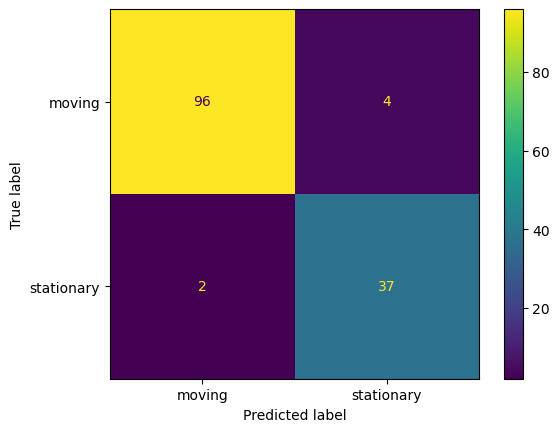

In [80]:
ConfusionMatrixDisplay.from_predictions(ds_EPC_norm['actual'], ds_EPC_norm['pred_ml'])

In [81]:
print(classification_report(ds_EPC_norm['actual'], ds_EPC_norm['pred_ml']))

              precision    recall  f1-score   support

      moving       0.98      0.96      0.97       100
  stationary       0.90      0.95      0.92        39

    accuracy                           0.96       139
   macro avg       0.94      0.95      0.95       139
weighted avg       0.96      0.96      0.96       139



In [82]:
ds_EPC_norm

,EPC,window_id,slot_center,pred_ml,actual,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,...,RSSI_min_1_ain,RSSI_min_1_aout,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout
0,AD3830770CCDD0AD383001C3,6_7_8_9_10_11,9,stationary,moving,0,1,0,1,0,...,0.000000,0.000000,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000
1,AD3830770CCDD0AD383001C4,6_7_8_9_10_11,9,stationary,stationary,0,0,0,1,0,...,0.000000,0.079433,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433
2,AD3830770CCDD0AD383001C8,6_7_8_9_10_11,9,moving,moving,0,1,0,1,1,...,1.778279,0.000000,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000
3,AD3830770CCDD0AD383001C9,6_7_8_9_10_11,9,moving,moving,0,0,0,1,1,...,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000
4,AD3830770CCDD0AD383001CB,6_7_8_9_10_11,9,moving,moving,0,1,0,1,1,...,0.000000,0.100000,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,AD3830770CCDD0AD383004AA,6_7_8_9_10_11,9,moving,moving,0,1,0,1,1,...,0.281838,0.000000,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000
135,AD3830770CCDD0AD383004AF,6_7_8_9_10_11,9,moving,moving,0,2,0,1,1,...,1.000000,0.000000,0.0,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000
136,AD3830770CCDD0AD383004B1,6_7_8_9_10_11,9,moving,moving,0,1,0,1,0,...,0.100000,0.000000,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000
137,AD3830770CCDD0AD383004B2,6_7_8_9_10_11,9,moving,moving,0,0,0,1,0,...,0.000000,0.177828,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828


In [83]:
tags['slot_id'].nunique()

18

In [84]:
tags

,EPC,Timestamp,Antenna,RSSI,RSSIdbm,actual,Antenna_coverage,slotStart,slot_id
0,AD3830770CCDD0AD3830047A,2022-05-19 14:41:50.053503,1,0.112202,-69.5,stationary,ain,2022-05-19 14:41:50.053503,0
1,AD3830770CCDD0AD3830039C,2022-05-19 14:41:50.092369,1,0.028184,-75.5,stationary,ain,2022-05-19 14:41:50.053503,0
2,AD3830770CCDD0AD38300324,2022-05-19 14:41:50.123705,2,0.100000,-70.0,stationary,ain,2022-05-19 14:41:50.053503,0
3,AD3830770CCDD0AD383002E6,2022-05-19 14:41:50.157848,2,0.039811,-74.0,stationary,ain,2022-05-19 14:41:50.053503,0
4,AD3830770CCDD0AD383002A5,2022-05-19 14:41:50.182130,2,0.044668,-73.5,stationary,ain,2022-05-19 14:41:50.053503,0
...,...,...,...,...,...,...,...,...,...
803,AD3830770CCDD0AD38300312,2022-05-19 14:42:07.080570,4,0.044668,-73.5,stationary,aout,2022-05-19 14:42:07.053503,17
804,AD3830770CCDD0AD38300453,2022-05-19 14:42:07.097300,4,0.050119,-73.0,stationary,aout,2022-05-19 14:42:07.053503,17
805,AD3830770CCDD0AD38300482,2022-05-19 14:42:07.149223,1,0.063096,-72.0,moving,ain,2022-05-19 14:42:07.053503,17
806,AD3830770CCDD0AD383003D6,2022-05-19 14:42:07.160984,1,0.028184,-75.5,moving,ain,2022-05-19 14:42:07.053503,17


In [85]:
ds_EPC_norm

,EPC,window_id,slot_center,pred_ml,actual,RSSI_len_-2_ain,RSSI_len_-2_aout,RSSI_len_-1_ain,RSSI_len_-1_aout,RSSI_len_0_ain,...,RSSI_min_1_ain,RSSI_min_1_aout,RSSI_sum_-2_ain,RSSI_sum_-2_aout,RSSI_sum_-1_ain,RSSI_sum_-1_aout,RSSI_sum_0_ain,RSSI_sum_0_aout,RSSI_sum_1_ain,RSSI_sum_1_aout
0,AD3830770CCDD0AD383001C3,6_7_8_9_10_11,9,stationary,moving,0,1,0,1,0,...,0.000000,0.000000,0.0,0.112202,0.0,0.056234,0.000000,0.056234,0.000000,0.000000
1,AD3830770CCDD0AD383001C4,6_7_8_9_10_11,9,stationary,stationary,0,0,0,1,0,...,0.000000,0.079433,0.0,0.000000,0.0,0.079433,0.000000,0.150227,0.000000,0.179433
2,AD3830770CCDD0AD383001C8,6_7_8_9_10_11,9,moving,moving,0,1,0,1,1,...,1.778279,0.000000,0.0,0.251189,0.0,0.141254,0.794328,0.000000,1.778279,0.000000
3,AD3830770CCDD0AD383001C9,6_7_8_9_10_11,9,moving,moving,0,0,0,1,1,...,0.000000,0.000000,0.0,0.000000,0.0,0.100000,0.199526,0.000000,0.000000,0.000000
4,AD3830770CCDD0AD383001CB,6_7_8_9_10_11,9,moving,moving,0,1,0,1,1,...,0.000000,0.100000,0.0,0.100000,0.0,0.177828,0.630957,0.000000,0.000000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,AD3830770CCDD0AD383004AA,6_7_8_9_10_11,9,moving,moving,0,1,0,1,1,...,0.281838,0.000000,0.0,0.050119,0.0,0.316228,0.501187,0.000000,0.281838,0.000000
135,AD3830770CCDD0AD383004AF,6_7_8_9_10_11,9,moving,moving,0,2,0,1,1,...,1.000000,0.000000,0.0,0.203158,0.0,0.079433,0.125893,0.177828,1.000000,0.000000
136,AD3830770CCDD0AD383004B1,6_7_8_9_10_11,9,moving,moving,0,1,0,1,0,...,0.100000,0.000000,0.0,0.070795,0.0,0.223872,0.000000,0.000000,0.100000,0.000000
137,AD3830770CCDD0AD383004B2,6_7_8_9_10_11,9,moving,moving,0,0,0,1,0,...,0.000000,0.177828,0.0,0.000000,0.0,0.158489,0.000000,0.000000,0.000000,0.177828


In [86]:
type(ds_EPC_norm)

pandas.core.frame.DataFrame

In [87]:
ds_EPC_norm.to_csv("ds_EPC_norm.csv", encoding='utf-8')